In [1]:
import numpy as np
from scipy import special, optimize
from math import factorial as fact
import matplotlib.pyplot as plt
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.rcParams['font.size'] = 15
plt.rcParams["axes.labelsize"] = 15
pd.options.display.float_format = "{:.4f}".format

# image

In [2]:
def para(a,b,theta):
    alpha = np.sqrt(a**2*np.cos(theta)**2 + b**2*np.sin(theta)**2)
    beta  = np.sqrt(b**2*np.cos(theta)**2 + a**2*np.sin(theta)**2)
    gamma = np.sin(2*theta)*(a**2-b**2)/(2*alpha*beta)
    return alpha,beta,gamma


def k(alpha, beta, gamma):
    """normalizing constant for PSF"""
    K = beta*alpha*np.sqrt(1 - gamma*gamma) / (2*np.pi)
    return K


def integrate_lim(x,y,thetaX,thetaY,alpha,beta,a):
    """integration limits for mu_prime"""
    u1 = alpha * (x-thetaX-a/2)
    u2 = alpha * (x-thetaX+a/2)
    v1 = beta  * (y-thetaY-a/2)
    v2 = beta  * (y-thetaY+a/2)
    return u1,u2,v1,v2
   
    
def numIntegrand_muP(x,y1,y2,gamma):
    """integrand of mu_prime, integrate over x, constants y1 & y2"""
    deltaErf = special.erf((y2+x*gamma)/np.sqrt(2))-special.erf((y1+x*gamma)/np.sqrt(2)) 
    integrand = np.sqrt(np.pi/2) * np.exp(x*x*(gamma*gamma-1)/2)*deltaErf
    return integrand


def numIntegrate(x1,x2,y1,y2,gamma,numSteps,integrand):
    """numerical integration of mu_prime, integration over x"""
    x = np.linspace(x1,x2,numSteps)
    h = (x2-x1)/(numSteps-1)
    trapzSum = 0
    for i in range(len(x)):
        trapzSum += integrand(x[i],y1,y2,gamma) * h
    trapzSum = trapzSum - h/2 * (integrand(x[0],y1,y2,gamma)+integrand(x[-1],y1,y2,gamma))
    return trapzSum


def mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps):
    """integrate analytically and numerically"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    mu_p = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(val) for val in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                mu_p[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,numIntegrand_muP)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                mu_p[i,j] = numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,numIntegrand_muP)
    return mu_p



def mu(x,y,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """image model for gaussian psf"""
    K1 = k(alpha1, beta1, gamma1)
    K2 = k(alpha2, beta2, gamma2)
    mu_p1 = mu_prime(x,y,X1,Y1,alpha1,beta1,gamma1,a,numSteps)
    mu_p2 = mu_prime(x,y,X2,Y2,alpha2,beta2,gamma2,a,numSteps)
    mu = I1*K1*mu_p1/alpha1/beta1 + I2*K2*mu_p2/alpha2/beta2 + thetabg*a**2
    return mu


# bounds

In [3]:
def dmu_dthetaI0(x,y,thetaX,thetaY,a,numSteps,alpha, beta, gamma):
    """derivative of mu wrt thetaI0"""
    K = k(alpha, beta, gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps)
    dmu_dthetaI0 = K/alpha/beta * mu_p
    return dmu_dthetaI0


def dmu_dthetabg(a):
    """derivative of mu wrt thetabg"""
    d = a**2
    return d


def dErf(x,y1,y2,gamma):
    """delta error functions for thetaX, thetaY derivatives"""
    deltaErf = special.erf((y1+x*gamma)/np.sqrt(2))-special.erf((y2+x*gamma)/np.sqrt(2)) 
    return deltaErf


def dmu_dthetaX(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0):
    """derivative of mu wrt thetaX"""
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    derf_u1 = dErf(u1,v2,v1,gamma)
    derf_u2 = dErf(u2,v2,v1,gamma)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2 - np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1
    dmu_dthetaX = thetaI0*K*(-alpha)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaX


def dmu_dthetaY(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0):
    """derivative of mu wrt thetaY"""
    K = k(alpha, beta, gamma)/alpha/beta
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    derf_v1 = dErf(v1,u2,u1,gamma)
    derf_v2 = dErf(v2,u2,u1,gamma)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2 - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1
    dmu_dthetaY = thetaI0*K*(-beta)*np.sqrt(np.pi/2)*bracket
    return dmu_dthetaY


def dK(alpha, beta, gamma, dAlpha=False, dBeta=False, dGamma=False):
    """derivatives of K wrt alpha, beta, gamma"""
    if dAlpha:
        dK = beta*np.sqrt(1-gamma*gamma)/(2*np.pi)
    elif dBeta: 
        dK = alpha*np.sqrt(1-gamma*gamma)/(2*np.pi)
    elif dGamma:
        dK = -alpha*beta*gamma/(2*np.pi*np.sqrt(1-gamma*gamma))
    return dK


def dmu_dalpha(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0, numSteps):
    """derivative of image model wrt alpha"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    derf_u1 = dErf(u1,v2,v1,gamma)
    derf_u2 = dErf(u2,v2,v1,gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps)
    bracket = np.exp(u2*u2*(gamma*gamma-1)/2)*derf_u2*(x-thetaX+a/2)- np.exp(u1*u1*(gamma*gamma-1)/2)*derf_u1*(x-thetaX-a/2) 
    dK_dalpha = dK(alpha, beta, gamma, dAlpha=True)
    dmuP_dalpha = np.sqrt(np.pi/2)*bracket
    dmu_dalpha = -thetaI0/beta * (dK_dalpha*mu_p/alpha - K*mu_p/alpha**2 + K/alpha*dmuP_dalpha)
    return dmu_dalpha


def dmu_dbeta(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of image model wrt beta"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    derf_v1 = dErf(v1,u2,u1,gamma)
    derf_v2 = dErf(v2,u2,u1,gamma)
    mu_p = mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps)
    bracket = np.exp(v2*v2*(gamma*gamma-1)/2)*derf_v2*(y-thetaY+a/2) - np.exp(v1*v1*(gamma*gamma-1)/2)*derf_v1*(y-thetaY-a/2)
    dK_dbeta = dK(alpha, beta, gamma, dBeta=True)
    dmuP_dbeta = np.sqrt(np.pi/2)*bracket
    dmu_dbeta = -thetaI0/alpha * (dK_dbeta*mu_p/beta - K*mu_p/beta**2 + K/beta*dmuP_dbeta)
    return dmu_dbeta


def dmuPrime_dGamma_integrand(x,y1,y2,gamma):
    """derivative of mu_prime wrt gamma integrand"""
    #integrate over x
    brac1 = 2+np.exp((y1+x*gamma)**2/2)*np.sqrt(2*np.pi)*x*gamma*special.erf((y1+x*gamma)/np.sqrt(2))
    brac2 = 2+np.exp((y2+x*gamma)**2/2)*np.sqrt(2*np.pi)*x*gamma*special.erf((y2+x*gamma)/np.sqrt(2))
    p1 = np.exp(-y1**2/2-0.5*x*(x+2*y1*gamma))*brac1
    p2 = np.exp(-y2**2/2-0.5*x*(x+2*y2*gamma))*brac2
    integrand = 0.5*x*(p2-p1)
    return integrand


def dmuPrime_dGamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of mu_prime wrt gamma"""
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    dmuPrime_dGamma = np.zeros(x.shape)
    for i in range(len(x)):
        for j in range(len(y)):
            maxVal = max([abs(i) for i in [u1[i,j],u2[i,j],v1[i,j],v2[i,j]]])
            if maxVal == abs(u1[i,j]) or maxVal == abs(u2[i,j]):
                #integrate numerically over u
                dmuPrime_dGamma[i,j] = numIntegrate(u1[i,j],u2[i,j],v1[i,j],v2[i,j],gamma,numSteps,dmuPrime_dGamma_integrand)
            elif maxVal == abs(v1[i,j]) or maxVal == abs(v2[i,j]):
                dmuPrime_dGamma[i,j] =  numIntegrate(v1[i,j],v2[i,j],u1[i,j],u2[i,j],gamma,numSteps,dmuPrime_dGamma_integrand)
    return dmuPrime_dGamma


def dmu_dgamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps):
    """derivative of image model wrt gamma"""
    K = k(alpha, beta, gamma)
    u1,u2,v1,v2 = integrate_lim(x,y,thetaX,thetaY,alpha,beta,a)
    dK_dgamma = dK(alpha, beta, gamma, dGamma=True)
    mu_p = mu_prime(x,y,thetaX,thetaY,alpha, beta, gamma,a,numSteps)
    dmuP_dgamma = dmuPrime_dGamma(x,y,thetaX,thetaY,a,alpha,beta,gamma,thetaI0,numSteps)
    dmu_dgamma = thetaI0/alpha/beta * (K*dmuP_dgamma + dK_dgamma*mu_p)
    return dmu_dgamma

In [4]:
def takeDer(para,x,y,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps):
    """take derivatives options"""
    if para == "X1":
        der = dmu_dthetaX(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1)
    elif para == "Y1":
        der = dmu_dthetaY(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1)
    elif para == "I1":
        der = dmu_dthetaI0(x,y,X1,Y1,a,numSteps,alpha1, beta1, gamma1)
    elif para == "alpha1":
        der = dmu_dalpha(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1, numSteps)
    elif para == "beta1":
        der = dmu_dbeta(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1,numSteps)
    elif para == "gamma1":
        der = dmu_dgamma(x,y,X1,Y1,a,alpha1,beta1,gamma1,I1,numSteps)
        
    elif para == "X2":
        der = dmu_dthetaX(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2)
    elif para == "Y2":
        der = dmu_dthetaY(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2)
    elif para == "I2":
        der = dmu_dthetaI0(x,y,X2,Y2,a,numSteps,alpha2, beta2, gamma2)
    elif para == "alpha2":
        der = dmu_dalpha(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2, numSteps)
    elif para == "beta2":
        der = dmu_dbeta(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2,numSteps)
    elif para == "gamma2":
        der = dmu_dgamma(x,y,X2,Y2,a,alpha2,beta2,gamma2,I2,numSteps)
        
    elif para == "thetabg":
        der = dmu_dthetabg(a)
    return der


def fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """calculate fisher matrix"""
    paras = ["X1", "Y1", "I1", "alpha1", "beta1","gamma1",
            "X2", "Y2", "I2", "alpha2", "beta2","gamma2","thetabg"]
    n = len(paras)
    fisher = np.zeros((n,n))
    
    x, y = np.arange(xmax), np.arange(ymax)
    xs, ys = np.meshgrid(x,y)
    ys = np.flipud(ys)
    mus= mu(xs,ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)

    for i in range(n):
        for j in range(n):
            fisher[i,j] = np.sum(1/mus * takeDer(paras[i],xs,ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps) * \
                                 takeDer(paras[j],xs,ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps))
    return fisher


def crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    fisherInv = np.linalg.inv(fisherM)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    print("#",end="")
    return crlbs


# no correction, separation test

In [5]:
theta1, theta2 = 0,0
width1 = 2
height1 = 2
width2 = 2
height2 = 2
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X
Y1 = Y
X2 = X
Y2 = Y
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 500
I2 = 500
sep = np.arange(0.5,8.5,0.5)


In [7]:
sep

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5,
       7. , 7.5, 8. ])

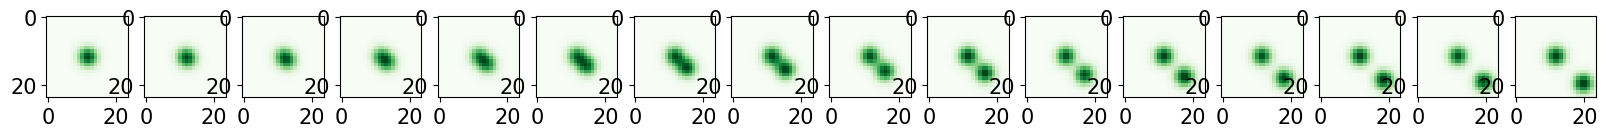

In [8]:
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
fig, ax = plt.subplots(1,len(sep),figsize=(20,4))
for i in range(len(sep)):
    m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2+sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    ax[i].imshow(m,cmap="Greens")

In [9]:
crlbs45 = [crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2+sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg) for i in range(len(sep))]

################

In [10]:
center_bound45 = [crlbs45[i][6]+crlbs45[i][7] for i in range(len(crlbs45))]
offCenter_bound45 = [crlbs45[i][0]+crlbs45[i][1] for i in range(len(crlbs45))]

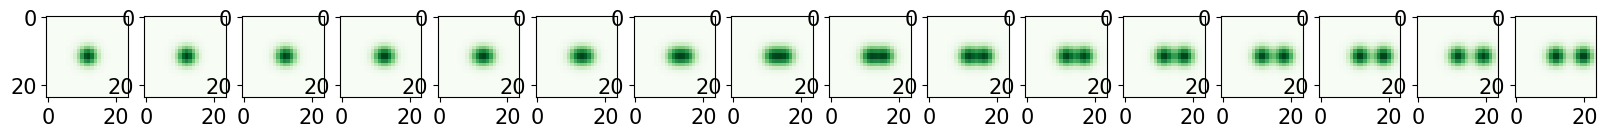

In [11]:
fig, ax = plt.subplots(1,len(sep),figsize=(20,4))
for i in range(len(sep)):
    m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    ax[i].imshow(m,cmap="Greens")

In [12]:
crlbs0 = [crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg) for i in range(len(sep))]


################

In [13]:
center_bound0 = [crlbs0[i][6]+crlbs0[i][7] for i in range(len(crlbs0))]
offCenter_bound0 = [crlbs0[i][0]+crlbs0[i][1] for i in range(len(crlbs0))]

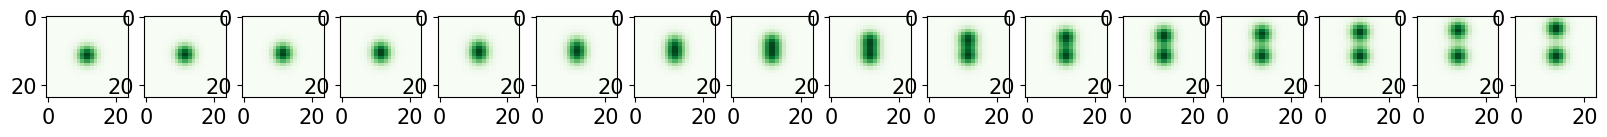

In [14]:
fig, ax = plt.subplots(1,len(sep),figsize=(20,4))
for i in range(len(sep)):
    m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2-sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    ax[i].imshow(m,cmap="Greens")

In [15]:
crlbs90 = [crlb(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2-sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg) for i in range(len(sep))]
center_bound90 = [crlbs90[i][6]+crlbs90[i][7] for i in range(len(crlbs90))]
offCenter_bound90 = [crlbs90[i][0]+crlbs90[i][1] for i in range(len(crlbs90))]

################

''

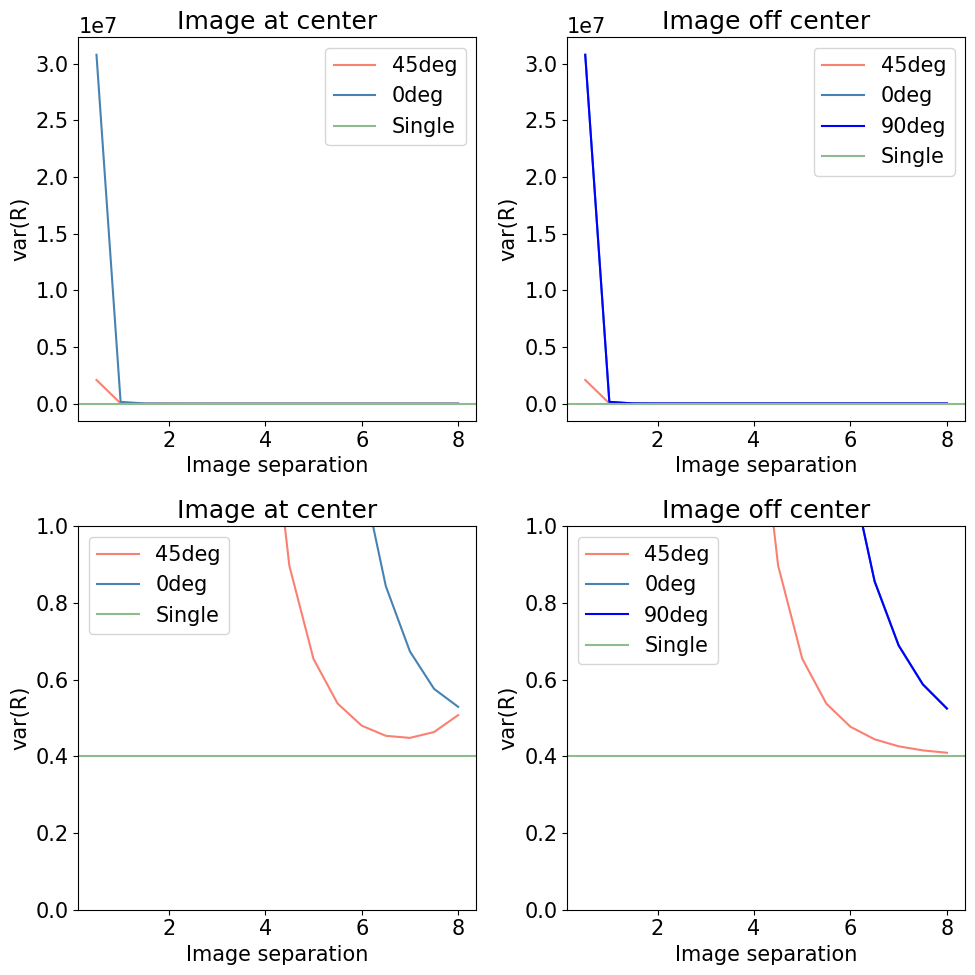

In [16]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
for j in range(2):
    ax[j,0].plot(sep,center_bound45, label="45deg",c="salmon") 
    ax[j,0].plot(sep,center_bound0, label="0deg", c="steelblue")
    #ax[0].plot(sep,center_bound90, label="90deg", c="blue")
    [ax[j,0].set_title("Image at center") for i in range(2)]

    ax[j,1].plot(sep,offCenter_bound45, label="45deg", c="salmon")
    ax[j,1].plot(sep,offCenter_bound0, label="0deg",c="steelblue")
    ax[j,1].plot(sep,offCenter_bound90, label="90deg", c="blue")
    [ax[j,1].set_title("Image off center") for i in range(2)]

    [ax[j,i].axhline(y = 0.40034, label = "Single",c="darkseagreen") for i in range(2)]
    [ax[j,i].set_xlabel("Image separation") for i in range(2)]
    [ax[j,i].set_ylabel("var(R)") for i in range(2)]
    [ax[j,i].legend() for i in range(2)]

[ax[1,i].set_ylim((0,1)) for i in range(2)]
fig.tight_layout()
;

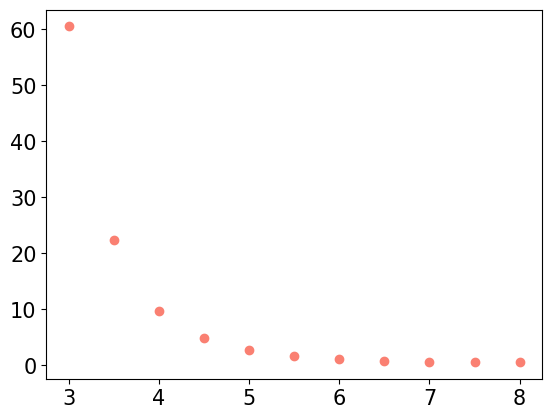

In [33]:
plt.scatter(sep[5:],center_bound0[5:], label="45deg",c="salmon") 

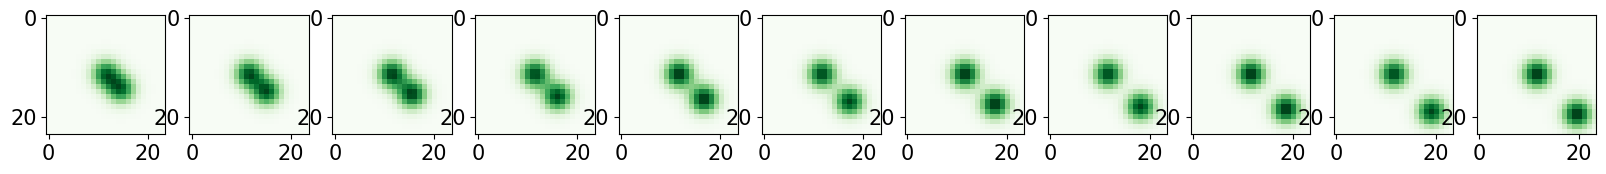

In [32]:
x,y = np.arange(xmax), np.arange(ymax)
xs, ys = np.meshgrid(x,y)
fig, ax = plt.subplots(1,len(sep)-5,figsize=(20,4))
for i in range(5,len(sep)):
    m = mu(xs, ys,X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2+sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    ax[i-5].imshow(m,cmap="Greens")

# test correction

In [8]:
parasL = ["X1", "Y1", "I1", "alpha1", "beta1","gamma1",
            "X2", "Y2", "I2", "alpha2", "beta2","gamma2","thetabg"]

def correct(fisherM):
    F = np.zeros(fisherM.shape)
    fisherInv = np.linalg.inv(fisherM)
    paras = [X1,Y1,I1,alpha1,beta1,gamma1,X2,Y2,I2,alpha2,beta2,gamma2,thetabg]
    
    for i in range(len(fisherM)):
        for j in range(len(fisherM)):
            if i in [0,1,6,7] and j in [0,1,6,7]:
                A = (paras[i] - paras[j])**2/(np.sqrt(fisherInv[i,i])*np.sqrt(fisherInv[j,j]))
                if (i%2 == 0 and j%2 == 0 and i!=j) or (i%2 != 0 and j%2 != 0 and i!=1 and j!=1 and i!=j):
                    F[i,j] = A/(A+1)*fisherM[i,j]
                else:
                    F[i,j] = fisherM[i,j]
    Finv = np.linalg.inv(F)
    return Finv

def correct(fisherM):
    F = fisherM
    fisherInv = np.linalg.inv(fisherM)
    paras = [X1,Y1,I1,alpha1,beta1,gamma1,X2,Y2,I2,alpha2,beta2,gamma2,thetabg]
    
    ind = [[6,0], [0,6],[1,7],[7,1]]
    
    Finv = np.linalg.inv(F)
    return Finv

def noCorrect(fisherM):
    fisherInv = np.linalg.inv(fisherM)
    return fisherInv

def getElements(Finv, fisherInv):
    bc = [Finv[i][i] for i in range(len(parasL))]
    bnc = [fisherInv[i][i] for i in range(len(parasL))]
    p = pd.DataFrame([parasL,bc,bnc],index=["para","Corrected","Not Corrected"]).T
    return p
    


def crlb_Cor(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg):
    """inverse fisher, retrieve CRLBs"""
    fisherM = fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2,Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    fisherInv = correct(fisherM)
    crlbs = [fisherInv[i,i] for i in range(len(fisherM))]
    print("#",end="")
    return crlbs

In [9]:
theta1, theta2 = 0,0
width1 = 2
height1 = 2
width2 = 2
height2 = 2
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X
Y1 = Y
X2 = X
Y2 = Y
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 500
I2 = 500

sep = np.arange(0.5,3.5,0.5)

for i in range(len(sep)):
    fisherM = fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2+sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    F = fisherM.copy()
    fisherInv = np.linalg.inv(fisherM)
    A60 = 0.1**2/(np.sqrt(fisherInv[6,6])*np.sqrt(fisherInv[0,0]))
    F[6,0] = A60/(A60+1)*fisherM[6,0]
    F[0,6] = A60/(A60+1)*fisherM[0,6]

    A17 = 0.1**2/(np.sqrt(fisherInv[1,1])*np.sqrt(fisherInv[7,7]))
    F[1,7] = A17/(A17+1)*fisherM[1,7]
    F[7,1] = A17/(A17+1)*fisherM[7,1]

    fI = np.linalg.inv(F)
    print([fI[j,j] for j in range(len(fI))])

[0.20086860711983662, 0.2008686071198366, -213091.89859855679, 0.06503101076804982, 0.0650310107680497, 0.5869068254807701, 0.2008686073449706, 0.20086860734497056, -213091.90249168652, 0.06503093423638244, 0.06503093423638232, 0.5869068360052052, 1.3221118684787234e-06]
[0.20817949618203552, 0.20817949618203546, -64540.92191502389, 0.022049006453653094, 0.0220490064536531, 0.1927114675913659, 0.20817949085280396, 0.208179490852804, -64540.92988064901, 0.02204890685721347, 0.022048906857213477, 0.19271157603688713, 1.4012502116412617e-06]
[0.21972954106774858, 0.21972954106774895, -40336.20093561162, 0.01589776080578616, 0.015897760805786157, 0.13229613842706106, 0.21972940841283656, 0.21972940841283636, -40336.2144665632, 0.015897648991579565, 0.01589764899157957, 0.1322965878771691, 1.4915369773101936e-06]
[0.17964050506458856, 0.17964050506458937, -38243.61493597672, 0.015610680697271761, 0.01561068069727177, 0.11624843197578524, 0.17963748472916938, 0.17963748472916793, -38243.6156

In [10]:
theta1, theta2 = 0,0
width1 = 2
height1 = 2
width2 = 2
height2 = 2
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X
Y1 = Y
X2 = X
Y2 = Y
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 500
I2 = 500

sep = np.arange(3.5,8.5,0.5)

for i in range(len(sep)):
    fisherM = fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2+sep[i],alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    F = fisherM.copy()
    fisherInv = np.linalg.inv(fisherM)
    A60 = 0.1**2/(np.sqrt(fisherInv[6,6])*np.sqrt(fisherInv[0,0]))
    F[6,0] = A60/(A60+1)*fisherM[6,0]
    F[0,6] = A60/(A60+1)*fisherM[0,6]

    A17 = 0.1**2/(np.sqrt(fisherInv[1,1])*np.sqrt(fisherInv[7,7]))
    F[1,7] = A17/(A17+1)*fisherM[1,7]
    F[7,1] = A17/(A17+1)*fisherM[7,1]

    fI = np.linalg.inv(F)
    print([fI[j,j] for j in range(len(fI))])

[1.3561553194697415, 1.3561553194697407, 99167.65678975664, 0.0187855554526944, 0.018785555452694353, 0.18748086510442477, 1.35621849206242, 1.3562184920624205, 99174.00972085288, 0.01882752969435775, 0.018827529694357747, 0.18766696238142253, 1.7027937914061013e-06]
[0.5986634187611137, 0.598663418761114, 35462.16882432588, 0.013230688559382213, 0.013230688559382232, 0.1198680585614718, 0.5985513140819807, 0.5985513140819805, 35470.59637551888, 0.013300904674107907, 0.013300904674107885, 0.12011182808472803, 1.7137461886967793e-06]
[0.3997218258878413, 0.3997218258878411, 21711.967205703804, 0.010927818850199882, 0.01092781885019988, 0.09703868412419782, 0.39948527797951006, 0.3994852779795099, 21725.63877294644, 0.011053757913427763, 0.011053757913427754, 0.09745373882387433, 1.712160292978542e-06]
[0.30914770216745185, 0.30914770216745163, 16589.78074974626, 0.00947874162819527, 0.009478741628195266, 0.08292872508116608, 0.30891575107240626, 0.30891575107240604, 16611.909128805448, 

In [11]:
theta1, theta2 = 0,0
width1 = 2
height1 = 2
width2 = 2
height2 = 2
alpha1,beta1,gamma1 = para(1/width1,1/height1,theta1)
alpha2,beta2,gamma2 = para(1/width2,1/height2,theta2)

xmax = 3*8
ymax = xmax
X = (xmax-1)/2
Y = X
X1 = X
Y1 = Y
X2 = X
Y2 = Y
a = 0.2
thetabg = 1e-5
numSteps = 30
I1 = 500
I2 = 500

sep = np.arange(0.5,8.5,0.5)

for i in range(len(sep)):
    fisherM = fisher(xmax, ymax, X1,Y1,alpha1,beta1,gamma1,I1,X2+sep[i],Y2,alpha2,beta2,gamma2,I2,a,numSteps,thetabg)
    F = fisherM.copy()
    fisherInv = np.linalg.inv(fisherM)
    A60 = 0.1**2/(np.sqrt(fisherInv[6,6])*np.sqrt(fisherInv[0,0]))
    F[6,0] = A60/(A60+1)*fisherM[6,0]
    F[0,6] = A60/(A60+1)*fisherM[0,6]

    A17 = 0.1**2/(np.sqrt(fisherInv[1,1])*np.sqrt(fisherInv[7,7]))
    F[1,7] = A17/(A17+1)*fisherM[1,7]
    F[7,1] = A17/(A17+1)*fisherM[7,1]

    fI = np.linalg.inv(F)
    print([fI[j,j] for j in range(len(fI))])

[-4.180359775969587e-06, 0.4004397408484869, -426149.75686360133, 0.0734194239109007, 0.20688052519427796, 0.8536049297497043, -4.180431963183319e-06, 0.4004397408544928, -426149.7435510916, 0.07341934808109297, 0.206880525017899, 0.8536048593405509, 1.3060644625534817e-06]
[-0.00030444877349257405, 0.4016781814340068, -128644.78505180082, 0.0241424645345379, 0.05631046913549949, 0.2547555103012644, -0.00030444766728493153, 0.4016781811547817, -128644.79234589904, 0.02414237815594373, 0.05631046873512982, 0.2547555199581074, 1.3505281081929009e-06]
[-0.004519589547520359, 0.4059365024391367, -78929.26183340652, 0.01679288308282946, 0.0283426973439204, 0.14921470641926987, -0.004519610443215013, 0.4059364950332326, -78929.27071234361, 0.016792834088282037, 0.028342695001482864, 0.14921476779116666, 1.4064113002990582e-06]
[-0.03865290502946702, 0.4138758712990635, -71753.69690906027, 0.017061727820195605, 0.018489568719615997, 0.11956806393957145, -0.038655615258240246, 0.41387576809703

In [17]:
bounds = [[-4.180359775969587e-06, 0.4004397408484869, -426149.75686360133, 0.0734194239109007, 0.20688052519427796, 0.8536049297497043, -4.180431963183319e-06, 0.4004397408544928, -426149.7435510916, 0.07341934808109297, 0.206880525017899, 0.8536048593405509, 1.3060644625534817e-06],
[-0.00030444877349257405, 0.4016781814340068, -128644.78505180082, 0.0241424645345379, 0.05631046913549949, 0.2547555103012644, -0.00030444766728493153, 0.4016781811547817, -128644.79234589904, 0.02414237815594373, 0.05631046873512982, 0.2547555199581074, 1.3505281081929009e-06],
[-0.004519589547520359, 0.4059365024391367, -78929.26183340652, 0.01679288308282946, 0.0283426973439204, 0.14921470641926987, -0.004519610443215013, 0.4059364950332326, -78929.27071234361, 0.016792834088282037, 0.028342695001482864, 0.14921476779116666, 1.4064113002990582e-06],
[-0.03865290502946702, 0.4138758712990635, -71753.69690906027, 0.017061727820195605, 0.018489568719615997, 0.11956806393957145, -0.038655615258240246, 0.41387576809703513, -71753.70179872238, 0.017062703897141252, 0.018489560008861993, 0.11956856897027027, 1.4620984714208805e-06],
[-0.2577773643770144, 0.4226394554475906, -93463.56014517885, 0.01977144294546361, 0.013886673020897144, 0.11419460533519818, -0.257842398929354, 0.4226386413089686, -93463.56541622871, 0.019777675808617362, 0.013886653550646886, 0.11419726017279358, 1.5137661538418713e-06],
[-1.9081009727122171, 0.4243637768417367, -244732.13185879172, 0.014021665595653193, 0.011361246388341828, 0.11822887432965692, -1.9092699736905392, 0.42435966302305056, -244733.34309581295, 0.014027755909968229, 0.011361222537235757, 0.11823969589495952, 1.5607526363112362e-06],
[3.1164604329909738, 0.409419009206776, 239963.8636434111, 0.03736964020263916, 0.009825460298725955, 0.12255051458310141, 3.1202051403756483, 0.4094042040112024, 239971.88701113575, 0.03752472162201316, 0.009825465390782794, 0.12258585081882242, 1.6029146939092418e-06],
[1.2681823300924453, 0.3761846843399985, 78220.42922306104, 0.024953318505446832, 0.008823759393918298, 0.1209899397884464, 1.2706846126418674, 0.37614455952402087, 78231.54167208826, 0.0251693392088492, 0.00882389456587836, 0.12108491940567231, 1.640360115929665e-06],
[0.8569518312017681, 0.3347283152153535, 47152.73405057782, 0.0206422826510494, 0.00813744416170312, 0.11301483915940075, 0.8591744088112204, 0.33464210996754906, 47175.0794693677, 0.021011572856196543, 0.008137968354695052, 0.11323228871048477, 1.6730817092708576e-06],
[0.6673324364522107, 0.29668282387714284, 34013.419515680616, 0.018358972001118922, 0.007650449371618702, 0.10205932284543726, 0.6687942234974089, 0.2965290241417643, 34059.11372013228, 0.0190016094985955, 0.0076519732804351025, 0.10250373224104745, 1.7011098004991234e-06],
[0.5537075090912218, 0.26719412309297463, 26648.414526664215, 0.016936797355066483, 0.0072962034604790345, 0.0912919208936488, 0.5532679553598002, 0.26696131075897134, 26737.417927126964, 0.01803328560282192, 0.007300076178647914, 0.09213253909263815, 1.7244124280314261e-06],
[0.47345050968004604, 0.24616013368435935, 21911.130727419368, 0.01580354135830788, 0.007034075441971123, 0.08212793944565386, 0.4695544554930422, 0.24587020210457677, 22073.170344671864, 0.017595779565122018, 0.007043106333478435, 0.0836296309304152, 1.743021491786104e-06],
[0.4113034293947889, 0.2316753327925992, 18697.327319240856, 0.014690210989964056, 0.006838003134624332, 0.07480835801594234, 0.40286460777019883, 0.23143063726669977, 18973.932582189736, 0.017471885477105195, 0.006857713091251834, 0.07737812008191187, 1.7570796130650766e-06],
[0.36180880184365755, 0.2218055246115506, 16513.86700930136, 0.013531320338227631, 0.00669044406330504, 0.06910484031393607, 0.34970486312806676, 0.22187708086912014, 16965.769580103577, 0.017649005682026403, 0.006731071608065241, 0.07335316111866749, 1.7666796515959132e-06],
[0.32272912241924345, 0.21506892056822757, 15059.926320624916, 0.012371355443639525, 0.006579043050116858, 0.06468826717560246, 0.31160602783944347, 0.21605507816825636, 15789.589174346094, 0.018236423323530034, 0.006658523792337159, 0.07148641161406626, 1.7720077182242517e-06],
[0.2926262440567671, 0.21045051599740214, 14116.187835240984, 0.01128701711883205, 0.006495044854617261, 0.06127594685232464, 0.2937654072521487, 0.21355765036004715, 15324.580894449813, 0.01941695584030107, 0.006643135149890078, 0.07183755282520747, 1.7733607161530365e-06]]

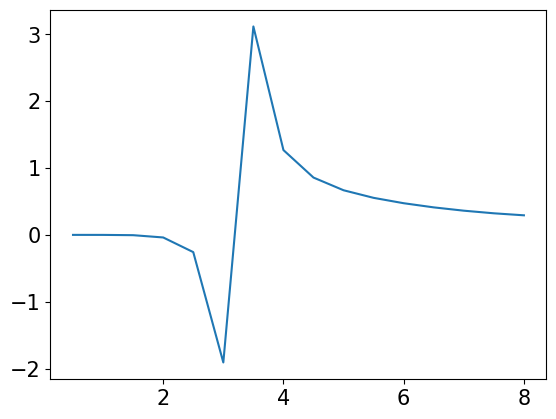

In [20]:
plt.plot(sep,[bounds[i][0] for i in range(len(bounds))])